# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [14]:
import gym
import numpy as np

In [15]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [16]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [17]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [18]:
batch[0], batch[0][1].shape

([1,
  array([-0.04166157,  0.21890391,  0.00132464, -0.24542417]),
  1.0,
  False,
  {}],
 (4,))

In [19]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [20]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
3.10735567715852 -2.8257436178344917


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [21]:
# Data of the model
def model_input(state_size):
    # Calculating Qs
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    
    # Calculated targetQs
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, rewards, targetQs

In [22]:
# Generator: Generating/prediting the actions
def generator(states, hidden_size, action_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [23]:
# Discriminator/Dopamine: Reward/Q netowrk
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fuse/merge the input states and action (sensorymotory input)
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer: logits/Qvalue & predictions/reward
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.sigmoid(logits)

        # return actions logits
        return logits

In [33]:
def model_loss(states, rewards, # Calculating Qs
               targetQs, # targetQs/nextQs
               action_size, hidden_size): # model init for Qs
        
    # # Calculate targetQs/nextQs
    # targetQs = sess.run(model.Qs, feed_dict={model.states: states, model.rewards: rewards})
                
    # calculate Qs and targetQs
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_preds = tf.nn.softmax(actions_logits)
    Qs_values = discriminator(actions=actions_preds, states=states, hidden_size=hidden_size)
    Qs = tf.multiply(Qs_values, tf.reshape(rewards, shape=[-1, 1]))
    
    # Calculating the loss: logits/predictions vs labels
    g_loss = tf.reduce_mean(tf.square(Qs[:-1] - targetQs[1:]))
    
    return actions_logits, Qs, g_loss

In [34]:
def model_opt(g_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

    return g_opt

In [36]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.rewards, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs, self.g_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            rewards=self.rewards, states=self.states, # Calculating Qs 
            targetQs=self.targetQs) # alculating targetQs/nextQs

        # Update the model: backward pass and backprop
        self.g_opt = model_opt(g_loss=self.g_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [37]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [38]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [39]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 50                # number of samples in the memory/ experience as mini-batch size

In [40]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [41]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Take one random step to get the pole and cart moving
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    reward = 1 - float(done)
    memory.buffer.append((action, state, reward))
    
    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [42]:
state, reward, action

(array([ 0.0373722 , -0.01835899,  0.00391915,  0.11036447]), 1.0, 0)

In [43]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting after training session/graph
rewards_list = [] # accuracy
g_loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        g_loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})
            rewarded_actions_logits = np.multiply(actions_logits, np.reshape(rewards, [-1, 1]))
            last_action_logits = rewarded_actions_logits[-1]
            
            # Explore (Env) or Exploit (Model)
            # Take new action, get new state and reward
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # Cumulative rewards
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            
            # Calculate targetQs/nextQs
            Qs = sess.run(model.Qs, feed_dict={model.states: states,
                                               model.rewards: rewards})
            targetQs = Qs.reshape([-1])
    
            # Updating the model using NEW memory and targetQs/nextQs
            feed_dict = {model.states: states, 
                         model.rewards: rewards, 
                         model.targetQs: targetQs}
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)

            # For average loss in one episode/epoch
            g_loss_batch.append(g_loss)

            # At the end of steps/batches loop
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average g_loss: {:.9f}'.format(np.mean(g_loss_batch)),
              'Explore P: {:.9f}'.format(explore_p))
        print('-------------------------------------------------------------------------------')

        # At the end of each episode/epoch
        # total rewards and losses for plotting
        rewards_list.append((ep, total_reward))
        g_loss_list.append((ep, np.mean(g_loss_batch)))
        
    # At the end of all training episodes/epochs
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
-------------------------------------------------------------------------------
Episode: 0 Total reward: 61.0 Average g_loss: 36.774513245 Explore P: 0.993880989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 14.0 Average g_loss: 60.142646790 Explore P: 0.992406273
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 13.0 Average g_loss: 104.208145142 Explore P: 0.991031867
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 13.0 Average g_loss: 134.118728638 Explore P: 0.989659383
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 34 Total reward: 49.0 Average g_loss: 75.150642395 Explore P: 0.924433679
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 30.0 Average g_loss: 62.888435364 Explore P: 0.921603323
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 12.0 Average g_loss: 109.594200134 Explore P: 0.920419009
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 37 Total reward: 23.0 Average g_loss: 108.901184082 Explore P: 0.918236623
-------------------------------------------------------------------------------
--------------------------

-------------------------------------------------------------------------------
Episode: 68 Total reward: 16.0 Average g_loss: 159.841934204 Explore P: 0.862953424
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 69 Total reward: 27.0 Average g_loss: 143.338241577 Explore P: 0.860568495
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 13.0 Average g_loss: 121.509468079 Explore P: 0.859378532
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 27.0 Average g_loss: 108.754165649 Explore P: 0.857003598
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 102 Total reward: 18.0 Average g_loss: 156.320816040 Explore P: 0.804096462
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 103 Total reward: 17.0 Average g_loss: 175.014602661 Explore P: 0.802668375
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 104 Total reward: 31.0 Average g_loss: 114.961502075 Explore P: 0.800135890
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 105 Total reward: 18.0 Average g_loss: 102.730247498 Explore P: 0.798636057
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 136 Total reward: 30.0 Average g_loss: 122.558815002 Explore P: 0.750336597
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 137 Total reward: 12.0 Average g_loss: 128.451522827 Explore P: 0.749374784
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 138 Total reward: 36.0 Average g_loss: 108.888267517 Explore P: 0.746644152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 139 Total reward: 25.0 Average g_loss: 77.617317200 Explore P: 0.744731365
-------------------------------------------------------------------------------
---------------------

-------------------------------------------------------------------------------
Episode: 170 Total reward: 40.0 Average g_loss: 130.414306641 Explore P: 0.702844054
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 171 Total reward: 14.0 Average g_loss: 110.909423828 Explore P: 0.701805567
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 172 Total reward: 18.0 Average g_loss: 135.133010864 Explore P: 0.700492384
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 173 Total reward: 12.0 Average g_loss: 179.318206787 Explore P: 0.699595327
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 205 Total reward: 10.0 Average g_loss: 185.619628906 Explore P: 0.662757008
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 206 Total reward: 15.0 Average g_loss: 202.767776489 Explore P: 0.661713432
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 207 Total reward: 20.0 Average g_loss: 180.563766479 Explore P: 0.660346269
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 208 Total reward: 13.0 Average g_loss: 151.598114014 Explore P: 0.659436422
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 239 Total reward: 13.0 Average g_loss: 119.659500122 Explore P: 0.624559004
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 240 Total reward: 13.0 Average g_loss: 133.827682495 Explore P: 0.623699223
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 241 Total reward: 28.0 Average g_loss: 137.504409790 Explore P: 0.621922073
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 242 Total reward: 9.0 Average g_loss: 142.110992432 Explore P: 0.621310457
-------------------------------------------------------------------------------
---------------------

-------------------------------------------------------------------------------
Episode: 274 Total reward: 19.0 Average g_loss: 160.611984253 Explore P: 0.583985964
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 275 Total reward: 14.0 Average g_loss: 182.737731934 Explore P: 0.583125631
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 276 Total reward: 11.0 Average g_loss: 181.395935059 Explore P: 0.582438292
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 277 Total reward: 17.0 Average g_loss: 175.207092285 Explore P: 0.581408830
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 308 Total reward: 20.0 Average g_loss: 124.260459900 Explore P: 0.551479357
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 309 Total reward: 19.0 Average g_loss: 131.394989014 Explore P: 0.550397480
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 310 Total reward: 9.0 Average g_loss: 164.529220581 Explore P: 0.549857353
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 311 Total reward: 16.0 Average g_loss: 175.639511108 Explore P: 0.548940375
-------------------------------------------------------------------------------
---------------------

-------------------------------------------------------------------------------
Episode: 344 Total reward: 16.0 Average g_loss: 177.074539185 Explore P: 0.521375904
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 345 Total reward: 12.0 Average g_loss: 187.711898804 Explore P: 0.520711547
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 346 Total reward: 11.0 Average g_loss: 183.970993042 Explore P: 0.520099060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 347 Total reward: 17.0 Average g_loss: 168.560485840 Explore P: 0.519181708
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 378 Total reward: 34.0 Average g_loss: 182.616897583 Explore P: 0.492173951
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 379 Total reward: 13.0 Average g_loss: 154.808959961 Explore P: 0.491499380
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 380 Total reward: 10.0 Average g_loss: 151.035018921 Explore P: 0.490970022
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 381 Total reward: 24.0 Average g_loss: 192.860839844 Explore P: 0.489769098
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 414 Total reward: 13.0 Average g_loss: 179.582199097 Explore P: 0.464321430
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 415 Total reward: 9.0 Average g_loss: 221.151657104 Explore P: 0.463867336
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 416 Total reward: 11.0 Average g_loss: 221.621597290 Explore P: 0.463323022
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 417 Total reward: 26.0 Average g_loss: 195.631271362 Explore P: 0.462100700
-------------------------------------------------------------------------------
---------------------

-------------------------------------------------------------------------------
Episode: 448 Total reward: 14.0 Average g_loss: 180.522186279 Explore P: 0.442207131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 449 Total reward: 12.0 Average g_loss: 196.418060303 Explore P: 0.441645627
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 450 Total reward: 10.0 Average g_loss: 196.123535156 Explore P: 0.441171078
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 451 Total reward: 9.0 Average g_loss: 226.360748291 Explore P: 0.440740122
-------------------------------------------------------------------------------
---------------------

-------------------------------------------------------------------------------
Episode: 482 Total reward: 20.0 Average g_loss: 182.296127319 Explore P: 0.421786472
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 483 Total reward: 11.0 Average g_loss: 184.422607422 Explore P: 0.421292625
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 484 Total reward: 14.0 Average g_loss: 180.155700684 Explore P: 0.420676148
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 485 Total reward: 13.0 Average g_loss: 176.801879883 Explore P: 0.420101604
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 517 Total reward: 12.0 Average g_loss: 174.607406616 Explore P: 0.401507606
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 518 Total reward: 19.0 Average g_loss: 165.048538208 Explore P: 0.400725373
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 519 Total reward: 7.0 Average g_loss: 171.262359619 Explore P: 0.400412918
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 520 Total reward: 13.0 Average g_loss: 197.526321411 Explore P: 0.399866722
-------------------------------------------------------------------------------
---------------------

-------------------------------------------------------------------------------
Episode: 552 Total reward: 12.0 Average g_loss: 195.767578125 Explore P: 0.380889785
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 553 Total reward: 12.0 Average g_loss: 195.114166260 Explore P: 0.380407942
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 554 Total reward: 12.0 Average g_loss: 198.467803955 Explore P: 0.379926724
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 555 Total reward: 14.0 Average g_loss: 203.633102417 Explore P: 0.379372250
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 588 Total reward: 8.0 Average g_loss: 248.807586670 Explore P: 0.363967444
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 589 Total reward: 11.0 Average g_loss: 244.984817505 Explore P: 0.363542938
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 590 Total reward: 15.0 Average g_loss: 240.964294434 Explore P: 0.362977722
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 591 Total reward: 15.0 Average g_loss: 205.266113281 Explore P: 0.362413409
-------------------------------------------------------------------------------
---------------------

-------------------------------------------------------------------------------
Episode: 623 Total reward: 34.0 Average g_loss: 149.537673950 Explore P: 0.346771596
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 624 Total reward: 12.0 Average g_loss: 119.996826172 Explore P: 0.346334077
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 625 Total reward: 20.0 Average g_loss: 119.040748596 Explore P: 0.345628517
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 626 Total reward: 22.0 Average g_loss: 156.418823242 Explore P: 0.344857458
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 658 Total reward: 18.0 Average g_loss: 180.438278198 Explore P: 0.330795851
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 659 Total reward: 16.0 Average g_loss: 209.076049805 Explore P: 0.330250962
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 660 Total reward: 9.0 Average g_loss: 176.171371460 Explore P: 0.329930871
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 661 Total reward: 8.0 Average g_loss: 181.237365723 Explore P: 0.329643062
-------------------------------------------------------------------------------
----------------------

-------------------------------------------------------------------------------
Episode: 694 Total reward: 13.0 Average g_loss: 187.922805786 Explore P: 0.313841123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 695 Total reward: 15.0 Average g_loss: 201.220870972 Explore P: 0.313355366
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 696 Total reward: 11.0 Average g_loss: 191.623825073 Explore P: 0.312991558
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 697 Total reward: 13.0 Average g_loss: 205.655883789 Explore P: 0.312567666
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 729 Total reward: 12.0 Average g_loss: 187.630676270 Explore P: 0.299427532
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 730 Total reward: 16.0 Average g_loss: 227.002151489 Explore P: 0.298935923
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 731 Total reward: 16.0 Average g_loss: 215.674896240 Explore P: 0.298445149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 732 Total reward: 12.0 Average g_loss: 192.739227295 Explore P: 0.298070414
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 764 Total reward: 10.0 Average g_loss: 217.488189697 Explore P: 0.286222015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 765 Total reward: 10.0 Average g_loss: 220.313095093 Explore P: 0.285918337
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 766 Total reward: 17.0 Average g_loss: 211.912460327 Explore P: 0.285422131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 767 Total reward: 12.0 Average g_loss: 196.268630981 Explore P: 0.285064315
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 800 Total reward: 24.0 Average g_loss: 186.437698364 Explore P: 0.272934498
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 801 Total reward: 14.0 Average g_loss: 152.847869873 Explore P: 0.272540392
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 802 Total reward: 10.0 Average g_loss: 159.101379395 Explore P: 0.272251756
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 803 Total reward: 12.0 Average g_loss: 174.454376221 Explore P: 0.271911050
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 835 Total reward: 12.0 Average g_loss: 210.951278687 Explore P: 0.261691704
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 836 Total reward: 11.0 Average g_loss: 216.247604370 Explore P: 0.261389855
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 837 Total reward: 13.0 Average g_loss: 199.643417358 Explore P: 0.261038156
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 838 Total reward: 12.0 Average g_loss: 190.854324341 Explore P: 0.260712018
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 871 Total reward: 8.0 Average g_loss: 249.208908081 Explore P: 0.250039848
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 872 Total reward: 11.0 Average g_loss: 246.869430542 Explore P: 0.249751973
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 873 Total reward: 14.0 Average g_loss: 243.054840088 Explore P: 0.249392615
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 874 Total reward: 9.0 Average g_loss: 250.658157349 Explore P: 0.249153342
-------------------------------------------------------------------------------
----------------------

-------------------------------------------------------------------------------
Episode: 905 Total reward: 11.0 Average g_loss: 227.001785278 Explore P: 0.240074908
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 906 Total reward: 11.0 Average g_loss: 232.201965332 Explore P: 0.239798984
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 907 Total reward: 13.0 Average g_loss: 236.444412231 Explore P: 0.239477490
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 908 Total reward: 14.0 Average g_loss: 218.313476562 Explore P: 0.239133532
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 939 Total reward: 13.0 Average g_loss: 220.372222900 Explore P: 0.230237155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 940 Total reward: 11.0 Average g_loss: 212.551742554 Explore P: 0.229973029
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 941 Total reward: 13.0 Average g_loss: 216.895629883 Explore P: 0.229665282
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 942 Total reward: 9.0 Average g_loss: 232.564254761 Explore P: 0.229445727
-------------------------------------------------------------------------------
---------------------

-------------------------------------------------------------------------------
Episode: 975 Total reward: 13.0 Average g_loss: 220.448577881 Explore P: 0.220672531
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 976 Total reward: 16.0 Average g_loss: 204.219680786 Explore P: 0.220314692
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 977 Total reward: 13.0 Average g_loss: 189.700592041 Explore P: 0.220020458
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 978 Total reward: 12.0 Average g_loss: 200.675537109 Explore P: 0.219747608
-------------------------------------------------------------------------------
--------------------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

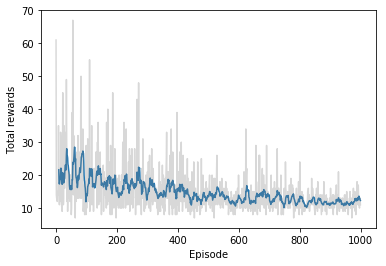

In [48]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average g_losses')

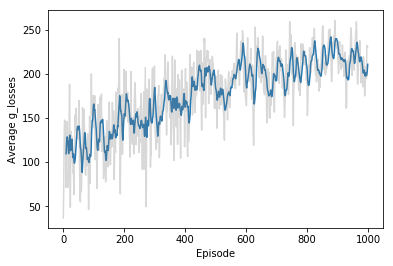

In [49]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average g_losses')

In [65]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Average d_losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):

        # Start a new episode/epoch
        env.reset()
        
        # number of env/rob steps
        for _ in range(test_max_steps):
            
            # Rendering the env graphics
            env.render()
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Take action, get new state and reward
            #action = env.action_space.sample()
            action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # The task is done or not;
            if done:
                break
                
# Closing the env
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.